推荐系统实战-3
=============
隐语义模型实战
------------

使用 [Text8](http://mattmahoney.net/dc/textdata) 数据集训练word2vec

1.安装依赖库

In [1]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
print('check：libs well prepared')

/Users/sangyongjia/anaconda3/envs/tf1.x/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sangyongjia/anaconda3/envs/tf1.x/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sangyongjia/anaconda3/envs/tf1.x/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sangyongjia/anaconda3/en

check：libs well prepared


2.下载数据并解压

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  #判断文件是否存在
  if not os.path.exists(filename):
    #下载
    print('download...')
    filename, _ = urlretrieve(url + filename, filename)
  #校验大小
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print('exception %s' % statinfo.st_size)
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


3.编码并替换低频次

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  #每个词出现的次数
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  #单词到数字的映射
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0 
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  #数字到单词的映射
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

#映射之后的训练数据
data, count, dictionary, reverse_dictionary = build_dataset(words)
#
print('Most common words (+UNK)', count[:5])
#print("dictionary data",dictionary)
#print("reverse_dictionary data",reverse_dictionary)
print('original data', words[:10])
print('training data', data[:10])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
original data ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
training data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


4.生成skip-gram训练数据

In [5]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  print(data_index)
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  # x y
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # context word context
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    # 循环使用
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # 
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels


print('data:', [reverse_dictionary[di] for di in data[:8]])
data_index = 0
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
0
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'a', 'of']


In [6]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

7
    batch: ['used', 'used', 'against', 'against', 'early', 'early', 'working', 'working']
    labels: ['against', 'first', 'early', 'used', 'working', 'against', 'class', 'early']


5.定义网络结构

In [7]:
batch_size = 128
embedding_size = 128 # 
skip_window = 1 # 
num_skips = 2 # 
valid_size = 16 # 
valid_window = 100 #
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 #

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # 输入数据
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # 定义变量
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  #本次训练数据对应的embedding
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # batch loss
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
  #优化loss，更新参数
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  #归一化
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  #用已有embedding计算valid的相似次
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead


6.运行训练流程

In [9]:
num_steps = 100000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  average_loss = 0
  for step in range(num_steps+1):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)

    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    #2000次打印loss
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # 打印valid效果
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 5 #相似度最高的5个词
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

14
Average loss at step 0: 7.753448
Nearest to four: starve, around, vowed, prolonging, bumped,
Nearest to two: abused, lomax, enactment, rutles, hecuba,
Nearest to one: andrade, thriving, safe, filius, vous,
Nearest to in: reproductive, ganesh, hamburger, meditations, reforms,
Nearest to some: koufax, hopi, keeshond, ora, fabric,
Nearest to is: preamble, midland, landsat, etiquette, craze,
Nearest to a: almoravids, percussive, postcode, clav, maratha,
Nearest to was: georg, spores, chianti, quotes, chinook,
Nearest to be: layered, subway, mohr, konya, datura,
Nearest to during: predictor, noticeable, deleterious, mana, pointy,
Nearest to and: shea, judi, garuda, mentha, radicalism,
Nearest to th: speculative, mature, mothers, hemophilia, stimulate,
Nearest to were: copra, broke, vertebrae, issued, occupiers,
Nearest to by: restaurants, brugha, electorate, pokes, hercules,
Nearest to time: straightforwardly, birger, bookrags, rooming, solving,
Nearest to that: univac, tojo, glottal, gi

84903
84970
85037
85104
85171
85238
85305
85372
85439
85506
85573
85640
85707
85774
85841
85908
85975
86042
86109
86176
86243
86310
86377
86444
86511
86578
86645
86712
86779
86846
86913
86980
87047
87114
87181
87248
87315
87382
87449
87516
87583
87650
87717
87784
87851
87918
87985
88052
88119
88186
88253
88320
88387
88454
88521
88588
88655
88722
88789
88856
88923
88990
89057
89124
89191
89258
89325
89392
89459
89526
89593
89660
89727
89794
89861
89928
89995
90062
90129
90196
90263
90330
90397
90464
90531
90598
90665
90732
90799
90866
90933
91000
91067
91134
91201
91268
91335
91402
91469
91536
91603
91670
91737
91804
91871
91938
92005
92072
92139
92206
92273
92340
92407
92474
92541
92608
92675
92742
92809
92876
92943
93010
93077
93144
93211
93278
93345
93412
93479
93546
93613
93680
93747
93814
93881
93948
94015
94082
94149
94216
94283
94350
94417
94484
94551
94618
94685
94752
94819
94886
94953
95020
95087
95154
95221
95288
95355
95422
95489
95556
95623
95690
95757
95824
95891
95958
9602

167112
167179
167246
167313
167380
167447
167514
167581
167648
167715
167782
167849
167916
167983
168050
168117
168184
168251
168318
168385
168452
168519
168586
168653
168720
168787
168854
168921
168988
169055
169122
169189
169256
169323
169390
169457
169524
169591
169658
169725
169792
169859
169926
169993
170060
170127
170194
170261
170328
170395
170462
170529
170596
170663
170730
170797
170864
170931
170998
171065
171132
171199
171266
171333
171400
171467
171534
171601
171668
171735
171802
171869
171936
172003
172070
172137
172204
172271
172338
172405
172472
172539
172606
172673
172740
172807
172874
172941
173008
173075
173142
173209
173276
173343
173410
173477
173544
173611
173678
173745
173812
173879
173946
174013
174080
174147
174214
174281
174348
174415
174482
174549
174616
174683
174750
174817
174884
174951
175018
175085
175152
175219
175286
175353
175420
175487
175554
175621
175688
175755
175822
175889
175956
176023
176090
176157
176224
176291
176358
176425
176492
176559
176626

247914
247981
248048
248115
248182
248249
248316
248383
248450
248517
248584
248651
248718
248785
248852
248919
248986
249053
249120
249187
249254
249321
249388
249455
249522
249589
249656
249723
249790
249857
249924
249991
250058
250125
250192
250259
250326
250393
250460
250527
250594
250661
250728
250795
250862
250929
250996
251063
251130
251197
251264
251331
251398
251465
251532
251599
251666
251733
251800
251867
251934
252001
252068
252135
252202
252269
252336
252403
252470
252537
252604
252671
252738
252805
252872
252939
253006
253073
253140
253207
253274
253341
253408
253475
253542
253609
253676
253743
253810
253877
253944
254011
254078
254145
254212
254279
254346
254413
254480
254547
254614
254681
254748
254815
254882
254949
255016
255083
255150
255217
255284
255351
255418
255485
255552
255619
255686
255753
255820
255887
255954
256021
256088
256155
256222
256289
256356
256423
256490
256557
256624
256691
256758
256825
256892
256959
257026
257093
257160
257227
257294
257361
257428

326103
326170
326237
326304
326371
326438
326505
326572
326639
326706
326773
326840
326907
326974
327041
327108
327175
327242
327309
327376
327443
327510
327577
327644
327711
327778
327845
327912
327979
328046
328113
328180
328247
328314
328381
328448
328515
328582
328649
328716
328783
328850
328917
328984
329051
329118
329185
329252
329319
329386
329453
329520
329587
329654
329721
329788
329855
329922
329989
330056
330123
330190
330257
330324
330391
330458
330525
330592
330659
330726
330793
330860
330927
330994
331061
331128
331195
331262
331329
331396
331463
331530
331597
331664
331731
331798
331865
331932
331999
332066
332133
332200
332267
332334
332401
332468
332535
332602
332669
332736
332803
332870
332937
333004
333071
333138
333205
333272
333339
333406
333473
333540
333607
333674
333741
333808
333875
333942
334009
334076
334143
334210
334277
334344
334411
334478
334545
334612
334679
334746
334813
334880
334947
335014
335081
335148
335215
335282
335349
335416
335483
335550
335617

407709
407776
407843
407910
407977
408044
408111
408178
408245
408312
408379
408446
408513
408580
408647
408714
408781
408848
408915
408982
409049
409116
409183
409250
409317
409384
409451
409518
409585
409652
409719
409786
409853
409920
409987
410054
410121
410188
410255
410322
410389
410456
410523
410590
410657
410724
410791
410858
410925
410992
411059
411126
411193
411260
411327
411394
411461
411528
411595
411662
411729
411796
411863
411930
411997
412064
412131
412198
412265
412332
412399
412466
412533
412600
412667
412734
412801
412868
412935
413002
413069
413136
413203
413270
413337
413404
413471
413538
413605
413672
413739
413806
413873
413940
414007
414074
414141
414208
414275
414342
414409
414476
414543
414610
414677
414744
414811
414878
414945
415012
415079
415146
415213
415280
415347
415414
415481
415548
415615
415682
415749
415816
415883
415950
416017
416084
416151
416218
416285
416352
416419
416486
416553
416620
416687
416754
416821
416888
416955
417022
417089
417156
417223

489248
489315
489382
489449
489516
489583
489650
489717
489784
489851
489918
489985
490052
490119
490186
490253
490320
490387
490454
490521
490588
490655
490722
490789
490856
490923
490990
491057
491124
491191
491258
491325
491392
491459
491526
491593
491660
491727
491794
491861
491928
491995
492062
492129
492196
492263
492330
492397
492464
492531
492598
492665
492732
492799
492866
492933
493000
493067
493134
493201
493268
493335
493402
493469
493536
493603
493670
493737
493804
493871
493938
494005
494072
494139
494206
494273
494340
494407
494474
494541
494608
494675
494742
494809
494876
494943
495010
495077
495144
495211
495278
495345
495412
495479
495546
495613
495680
495747
495814
495881
495948
496015
496082
496149
496216
496283
496350
496417
496484
496551
496618
496685
496752
496819
496886
496953
497020
497087
497154
497221
497288
497355
497422
497489
497556
497623
497690
497757
497824
497891
497958
498025
498092
498159
498226
498293
498360
498427
498494
498561
498628
498695
498762

567571
567638
567705
567772
567839
567906
567973
568040
568107
568174
568241
568308
568375
568442
568509
568576
568643
568710
568777
568844
568911
568978
569045
569112
569179
569246
569313
569380
569447
569514
569581
569648
569715
569782
569849
569916
569983
570050
570117
570184
570251
570318
570385
570452
570519
570586
570653
570720
570787
570854
570921
570988
571055
571122
571189
571256
571323
571390
571457
571524
571591
571658
571725
571792
571859
571926
571993
572060
572127
572194
572261
572328
572395
572462
572529
572596
572663
572730
572797
572864
572931
572998
573065
573132
573199
573266
573333
573400
573467
573534
573601
573668
573735
573802
573869
573936
574003
574070
574137
574204
574271
574338
574405
574472
574539
574606
574673
574740
574807
574874
574941
575008
575075
575142
575209
575276
575343
575410
575477
575544
575611
575678
575745
575812
575879
575946
576013
576080
576147
576214
576281
576348
576415
576482
576549
576616
576683
576750
576817
576884
576951
577018
577085

649646
649713
649780
649847
649914
649981
650048
650115
650182
650249
650316
650383
650450
650517
650584
650651
650718
650785
650852
650919
650986
651053
651120
651187
651254
651321
651388
651455
651522
651589
651656
651723
651790
651857
651924
651991
652058
652125
652192
652259
652326
652393
652460
652527
652594
652661
652728
652795
652862
652929
652996
653063
653130
653197
653264
653331
653398
653465
653532
653599
653666
653733
653800
653867
653934
654001
654068
654135
654202
654269
654336
654403
654470
654537
654604
654671
654738
654805
654872
654939
655006
655073
655140
655207
655274
655341
655408
655475
655542
655609
655676
655743
655810
655877
655944
656011
656078
656145
656212
656279
656346
656413
656480
656547
656614
656681
656748
656815
656882
656949
657016
657083
657150
657217
657284
657351
657418
657485
657552
657619
657686
657753
657820
657887
657954
658021
658088
658155
658222
658289
658356
658423
658490
658557
658624
658691
658758
658825
658892
658959
659026
659093
659160

722743
722810
722877
722944
723011
723078
723145
723212
723279
723346
723413
723480
723547
723614
723681
723748
723815
723882
723949
724016
724083
724150
724217
724284
724351
724418
724485
724552
724619
724686
724753
724820
724887
724954
725021
725088
725155
725222
725289
725356
725423
725490
725557
725624
725691
725758
725825
725892
725959
726026
726093
726160
726227
726294
726361
726428
726495
726562
726629
726696
726763
726830
726897
726964
727031
727098
727165
727232
727299
727366
727433
727500
727567
727634
727701
727768
727835
727902
727969
728036
728103
728170
728237
728304
728371
728438
728505
728572
728639
728706
728773
728840
728907
728974
729041
729108
729175
729242
729309
729376
729443
729510
729577
729644
729711
729778
729845
729912
729979
730046
730113
730180
730247
730314
730381
730448
730515
730582
730649
730716
730783
730850
730917
730984
731051
731118
731185
731252
731319
731386
731453
731520
731587
731654
731721
731788
731855
731922
731989
732056
732123
732190
732257

804684
804751
804818
804885
804952
805019
805086
805153
805220
805287
805354
805421
805488
805555
805622
805689
805756
805823
805890
805957
806024
806091
806158
806225
806292
806359
806426
806493
806560
806627
806694
806761
806828
806895
806962
807029
807096
807163
807230
807297
807364
807431
807498
807565
807632
807699
807766
807833
807900
807967
808034
808101
808168
808235
808302
808369
808436
808503
808570
808637
808704
808771
808838
808905
808972
809039
809106
809173
809240
809307
809374
809441
809508
809575
809642
809709
809776
809843
809910
809977
810044
810111
810178
810245
810312
810379
810446
810513
810580
810647
810714
810781
810848
810915
810982
811049
811116
811183
811250
811317
811384
811451
811518
811585
811652
811719
811786
811853
811920
811987
812054
812121
812188
812255
812322
812389
812456
812523
812590
812657
812724
812791
812858
812925
812992
813059
813126
813193
813260
813327
813394
813461
813528
813595
813662
813729
813796
813863
813930
813997
814064
814131
814198

883409
883476
883543
883610
883677
883744
883811
883878
883945
884012
884079
884146
884213
884280
884347
884414
884481
884548
884615
884682
884749
884816
884883
884950
885017
885084
885151
885218
885285
885352
885419
885486
885553
885620
885687
885754
885821
885888
885955
886022
886089
886156
886223
886290
886357
886424
886491
886558
886625
886692
886759
886826
886893
886960
887027
887094
887161
887228
887295
887362
887429
887496
887563
887630
887697
887764
887831
887898
887965
888032
888099
888166
888233
888300
888367
888434
888501
888568
888635
888702
888769
888836
888903
888970
889037
889104
889171
889238
889305
889372
889439
889506
889573
889640
889707
889774
889841
889908
889975
890042
890109
890176
890243
890310
890377
890444
890511
890578
890645
890712
890779
890846
890913
890980
891047
891114
891181
891248
891315
891382
891449
891516
891583
891650
891717
891784
891851
891918
891985
892052
892119
892186
892253
892320
892387
892454
892521
892588
892655
892722
892789
892856
892923

964814
964881
964948
965015
965082
965149
965216
965283
965350
965417
965484
965551
965618
965685
965752
965819
965886
965953
966020
966087
966154
966221
966288
966355
966422
966489
966556
966623
966690
966757
966824
966891
966958
967025
967092
967159
967226
967293
967360
967427
967494
967561
967628
967695
967762
967829
967896
967963
968030
968097
968164
968231
968298
968365
968432
968499
968566
968633
968700
968767
968834
968901
968968
969035
969102
969169
969236
969303
969370
969437
969504
969571
969638
969705
969772
969839
969906
969973
970040
970107
970174
970241
970308
970375
970442
970509
970576
970643
970710
970777
970844
970911
970978
971045
971112
971179
971246
971313
971380
971447
971514
971581
971648
971715
971782
971849
971916
971983
972050
972117
972184
972251
972318
972385
972452
972519
972586
972653
972720
972787
972854
972921
972988
973055
973122
973189
973256
973323
973390
973457
973524
973591
973658
973725
973792
973859
973926
973993
974060
974127
974194
974261
974328

1039519
1039586
1039653
1039720
1039787
1039854
1039921
1039988
1040055
1040122
1040189
1040256
1040323
1040390
1040457
1040524
1040591
1040658
1040725
1040792
1040859
1040926
1040993
1041060
1041127
1041194
1041261
1041328
1041395
1041462
1041529
1041596
1041663
1041730
1041797
1041864
1041931
1041998
1042065
1042132
1042199
1042266
1042333
1042400
1042467
1042534
1042601
1042668
1042735
1042802
1042869
1042936
1043003
1043070
1043137
1043204
1043271
1043338
1043405
1043472
1043539
1043606
1043673
1043740
1043807
1043874
1043941
1044008
1044075
1044142
1044209
1044276
1044343
1044410
1044477
1044544
1044611
1044678
1044745
1044812
1044879
1044946
1045013
1045080
1045147
1045214
1045281
1045348
1045415
1045482
1045549
1045616
1045683
1045750
1045817
1045884
1045951
1046018
1046085
1046152
1046219
1046286
1046353
1046420
1046487
1046554
1046621
1046688
1046755
1046822
1046889
1046956
1047023
1047090
1047157
1047224
1047291
1047358
1047425
1047492
1047559
1047626
1047693
1047760
1047827


1110673
1110740
1110807
1110874
1110941
1111008
1111075
1111142
1111209
1111276
1111343
1111410
1111477
1111544
1111611
1111678
1111745
1111812
1111879
1111946
1112013
1112080
1112147
1112214
1112281
1112348
1112415
1112482
1112549
1112616
1112683
1112750
1112817
1112884
1112951
1113018
1113085
1113152
1113219
1113286
1113353
1113420
1113487
1113554
1113621
1113688
1113755
1113822
1113889
1113956
1114023
1114090
1114157
1114224
1114291
1114358
1114425
1114492
1114559
1114626
1114693
1114760
1114827
1114894
1114961
1115028
1115095
1115162
1115229
1115296
1115363
1115430
1115497
1115564
1115631
1115698
1115765
1115832
1115899
1115966
1116033
1116100
1116167
1116234
1116301
1116368
1116435
1116502
1116569
1116636
1116703
1116770
1116837
1116904
1116971
1117038
1117105
1117172
1117239
1117306
1117373
1117440
1117507
1117574
1117641
1117708
1117775
1117842
1117909
1117976
1118043
1118110
1118177
1118244
1118311
1118378
1118445
1118512
1118579
1118646
1118713
1118780
1118847
1118914
1118981


1181224
1181291
1181358
1181425
1181492
1181559
1181626
1181693
1181760
1181827
1181894
1181961
1182028
1182095
1182162
1182229
1182296
1182363
1182430
1182497
1182564
1182631
1182698
1182765
1182832
1182899
1182966
1183033
1183100
1183167
1183234
1183301
1183368
1183435
1183502
1183569
1183636
1183703
1183770
1183837
1183904
1183971
1184038
1184105
1184172
1184239
1184306
1184373
1184440
1184507
1184574
1184641
1184708
1184775
1184842
1184909
1184976
1185043
1185110
1185177
1185244
1185311
1185378
1185445
1185512
1185579
1185646
1185713
1185780
1185847
1185914
1185981
1186048
1186115
1186182
1186249
1186316
1186383
1186450
1186517
1186584
1186651
1186718
1186785
1186852
1186919
1186986
1187053
1187120
1187187
1187254
1187321
1187388
1187455
1187522
1187589
1187656
1187723
1187790
1187857
1187924
1187991
1188058
1188125
1188192
1188259
1188326
1188393
1188460
1188527
1188594
1188661
1188728
1188795
1188862
1188929
1188996
1189063
1189130
1189197
1189264
1189331
1189398
1189465
1189532


1249698
1249765
1249832
1249899
1249966
1250033
1250100
1250167
1250234
1250301
1250368
1250435
1250502
1250569
1250636
1250703
1250770
1250837
1250904
1250971
1251038
1251105
1251172
1251239
1251306
1251373
1251440
1251507
1251574
1251641
1251708
1251775
1251842
1251909
1251976
1252043
1252110
1252177
1252244
1252311
1252378
1252445
1252512
1252579
1252646
1252713
1252780
1252847
1252914
1252981
1253048
1253115
1253182
1253249
1253316
1253383
1253450
1253517
1253584
1253651
1253718
1253785
1253852
1253919
1253986
1254053
1254120
1254187
1254254
1254321
1254388
1254455
1254522
1254589
1254656
1254723
1254790
1254857
1254924
1254991
1255058
1255125
1255192
1255259
1255326
1255393
1255460
1255527
1255594
1255661
1255728
1255795
1255862
1255929
1255996
1256063
1256130
1256197
1256264
1256331
1256398
1256465
1256532
1256599
1256666
1256733
1256800
1256867
1256934
1257001
1257068
1257135
1257202
1257269
1257336
1257403
1257470
1257537
1257604
1257671
1257738
1257805
1257872
1257939
1258006


1320182
1320249
1320316
1320383
1320450
1320517
1320584
1320651
1320718
1320785
1320852
1320919
1320986
1321053
1321120
1321187
1321254
1321321
1321388
1321455
1321522
1321589
1321656
1321723
1321790
1321857
1321924
1321991
1322058
1322125
1322192
1322259
1322326
1322393
1322460
1322527
1322594
1322661
1322728
1322795
1322862
1322929
1322996
1323063
1323130
1323197
1323264
1323331
1323398
1323465
1323532
1323599
1323666
1323733
1323800
1323867
1323934
1324001
1324068
1324135
1324202
1324269
1324336
1324403
1324470
1324537
1324604
1324671
1324738
1324805
1324872
1324939
1325006
1325073
1325140
1325207
1325274
1325341
1325408
1325475
1325542
1325609
1325676
1325743
1325810
1325877
1325944
1326011
1326078
1326145
1326212
1326279
1326346
1326413
1326480
1326547
1326614
1326681
1326748
1326815
1326882
1326949
1327016
1327083
1327150
1327217
1327284
1327351
1327418
1327485
1327552
1327619
1327686
1327753
1327820
1327887
1327954
1328021
1328088
1328155
1328222
1328289
1328356
1328423
1328490


1383363
1383430
1383497
1383564
1383631
1383698
1383765
1383832
1383899
1383966
1384033
1384100
1384167
1384234
1384301
1384368
1384435
1384502
1384569
1384636
1384703
1384770
1384837
1384904
1384971
1385038
1385105
1385172
1385239
1385306
1385373
1385440
1385507
1385574
1385641
1385708
1385775
1385842
1385909
1385976
1386043
1386110
1386177
1386244
1386311
1386378
1386445
1386512
1386579
1386646
1386713
1386780
1386847
1386914
1386981
1387048
1387115
1387182
1387249
1387316
1387383
1387450
1387517
1387584
1387651
1387718
1387785
1387852
1387919
1387986
1388053
1388120
1388187
1388254
1388321
1388388
1388455
1388522
1388589
1388656
1388723
1388790
1388857
1388924
1388991
1389058
1389125
1389192
1389259
1389326
1389393
1389460
1389527
1389594
1389661
1389728
1389795
1389862
1389929
1389996
1390063
1390130
1390197
1390264
1390331
1390398
1390465
1390532
1390599
1390666
1390733
1390800
1390867
1390934
1391001
1391068
1391135
1391202
1391269
1391336
1391403
1391470
1391537
1391604
1391671


1452105
1452172
1452239
1452306
1452373
1452440
1452507
1452574
1452641
1452708
1452775
1452842
1452909
1452976
1453043
1453110
1453177
1453244
1453311
1453378
1453445
1453512
1453579
1453646
1453713
1453780
1453847
1453914
1453981
1454048
1454115
1454182
1454249
1454316
1454383
1454450
1454517
1454584
1454651
1454718
1454785
1454852
1454919
1454986
1455053
1455120
1455187
1455254
1455321
1455388
1455455
1455522
1455589
1455656
1455723
1455790
1455857
1455924
1455991
1456058
1456125
1456192
1456259
1456326
1456393
1456460
1456527
1456594
1456661
1456728
1456795
1456862
1456929
1456996
1457063
1457130
1457197
1457264
1457331
1457398
1457465
1457532
1457599
1457666
1457733
1457800
1457867
1457934
1458001
1458068
1458135
1458202
1458269
1458336
1458403
1458470
1458537
1458604
1458671
1458738
1458805
1458872
1458939
1459006
1459073
1459140
1459207
1459274
1459341
1459408
1459475
1459542
1459609
1459676
1459743
1459810
1459877
1459944
1460011
1460078
1460145
1460212
1460279
1460346
1460413


1520914
1520981
1521048
1521115
1521182
1521249
1521316
1521383
1521450
1521517
1521584
1521651
1521718
1521785
1521852
1521919
1521986
1522053
1522120
1522187
1522254
1522321
1522388
1522455
1522522
1522589
1522656
1522723
1522790
1522857
1522924
1522991
1523058
1523125
1523192
1523259
1523326
1523393
1523460
1523527
1523594
1523661
1523728
1523795
1523862
1523929
1523996
1524063
1524130
1524197
1524264
1524331
1524398
1524465
1524532
1524599
1524666
1524733
1524800
1524867
1524934
1525001
1525068
1525135
1525202
1525269
1525336
1525403
1525470
1525537
1525604
1525671
1525738
1525805
1525872
1525939
1526006
1526073
1526140
1526207
1526274
1526341
1526408
1526475
1526542
1526609
1526676
1526743
1526810
1526877
1526944
1527011
1527078
1527145
1527212
1527279
1527346
1527413
1527480
1527547
1527614
1527681
1527748
1527815
1527882
1527949
1528016
1528083
1528150
1528217
1528284
1528351
1528418
1528485
1528552
1528619
1528686
1528753
1528820
1528887
1528954
1529021
1529088
1529155
1529222


1592537
1592604
1592671
1592738
1592805
1592872
1592939
1593006
1593073
1593140
1593207
1593274
1593341
1593408
1593475
1593542
1593609
1593676
1593743
1593810
1593877
1593944
1594011
1594078
1594145
1594212
1594279
1594346
1594413
1594480
1594547
1594614
1594681
1594748
1594815
1594882
1594949
1595016
1595083
1595150
1595217
1595284
1595351
1595418
1595485
1595552
1595619
1595686
1595753
1595820
1595887
1595954
1596021
1596088
1596155
1596222
1596289
1596356
1596423
1596490
1596557
1596624
1596691
1596758
1596825
1596892
1596959
1597026
1597093
1597160
1597227
1597294
1597361
1597428
1597495
1597562
1597629
1597696
1597763
1597830
1597897
1597964
1598031
1598098
1598165
1598232
1598299
1598366
1598433
1598500
1598567
1598634
1598701
1598768
1598835
1598902
1598969
1599036
1599103
1599170
1599237
1599304
1599371
1599438
1599505
1599572
1599639
1599706
1599773
1599840
1599907
1599974
1600041
1600108
1600175
1600242
1600309
1600376
1600443
1600510
1600577
1600644
1600711
1600778
1600845


1662820
1662887
1662954
1663021
1663088
1663155
1663222
1663289
1663356
1663423
1663490
1663557
1663624
1663691
1663758
1663825
1663892
1663959
1664026
1664093
1664160
1664227
1664294
1664361
1664428
1664495
1664562
1664629
1664696
1664763
1664830
1664897
1664964
1665031
1665098
1665165
1665232
1665299
1665366
1665433
1665500
1665567
1665634
1665701
1665768
1665835
1665902
1665969
1666036
1666103
1666170
1666237
1666304
1666371
1666438
1666505
1666572
1666639
1666706
1666773
1666840
1666907
1666974
1667041
1667108
1667175
1667242
1667309
1667376
1667443
1667510
1667577
1667644
1667711
1667778
1667845
1667912
1667979
1668046
1668113
1668180
1668247
1668314
1668381
1668448
1668515
1668582
1668649
1668716
1668783
1668850
1668917
1668984
1669051
1669118
1669185
1669252
1669319
1669386
1669453
1669520
1669587
1669654
1669721
1669788
1669855
1669922
1669989
1670056
1670123
1670190
1670257
1670324
1670391
1670458
1670525
1670592
1670659
1670726
1670793
1670860
1670927
1670994
1671061
1671128


1731629
1731696
1731763
1731830
1731897
1731964
1732031
1732098
1732165
1732232
1732299
1732366
1732433
1732500
1732567
1732634
1732701
1732768
1732835
1732902
1732969
1733036
1733103
1733170
1733237
1733304
1733371
1733438
1733505
1733572
1733639
1733706
1733773
1733840
1733907
1733974
1734041
1734108
1734175
1734242
1734309
1734376
1734443
1734510
1734577
1734644
1734711
1734778
1734845
1734912
1734979
1735046
1735113
1735180
1735247
1735314
1735381
1735448
1735515
1735582
1735649
1735716
1735783
1735850
1735917
1735984
1736051
1736118
1736185
1736252
1736319
1736386
1736453
1736520
1736587
1736654
1736721
1736788
1736855
1736922
1736989
1737056
1737123
1737190
1737257
1737324
1737391
1737458
1737525
1737592
1737659
1737726
1737793
1737860
1737927
1737994
1738061
1738128
1738195
1738262
1738329
1738396
1738463
1738530
1738597
1738664
1738731
1738798
1738865
1738932
1738999
1739066
1739133
1739200
1739267
1739334
1739401
1739468
1739535
1739602
1739669
1739736
1739803
1739870
1739937


1801644
1801711
1801778
1801845
1801912
1801979
1802046
1802113
1802180
1802247
1802314
1802381
1802448
1802515
1802582
1802649
1802716
1802783
1802850
1802917
1802984
1803051
1803118
1803185
1803252
1803319
1803386
1803453
1803520
1803587
1803654
1803721
1803788
1803855
1803922
1803989
1804056
1804123
1804190
1804257
1804324
1804391
1804458
1804525
1804592
1804659
1804726
1804793
1804860
1804927
1804994
1805061
1805128
1805195
1805262
1805329
1805396
1805463
1805530
1805597
1805664
1805731
1805798
1805865
1805932
1805999
1806066
1806133
1806200
1806267
1806334
1806401
1806468
1806535
1806602
1806669
1806736
1806803
1806870
1806937
1807004
1807071
1807138
1807205
1807272
1807339
1807406
1807473
1807540
1807607
1807674
1807741
1807808
1807875
1807942
1808009
1808076
1808143
1808210
1808277
1808344
1808411
1808478
1808545
1808612
1808679
1808746
1808813
1808880
1808947
1809014
1809081
1809148
1809215
1809282
1809349
1809416
1809483
1809550
1809617
1809684
1809751
1809818
1809885
1809952


1872932
1872999
1873066
1873133
1873200
1873267
1873334
1873401
1873468
1873535
1873602
1873669
1873736
1873803
1873870
1873937
1874004
1874071
1874138
1874205
1874272
1874339
1874406
1874473
1874540
1874607
1874674
1874741
1874808
1874875
1874942
1875009
1875076
1875143
1875210
1875277
1875344
1875411
1875478
1875545
1875612
1875679
1875746
1875813
1875880
1875947
1876014
Average loss at step 28000: 3.478452
1876081
1876148
1876215
1876282
1876349
1876416
1876483
1876550
1876617
1876684
1876751
1876818
1876885
1876952
1877019
1877086
1877153
1877220
1877287
1877354
1877421
1877488
1877555
1877622
1877689
1877756
1877823
1877890
1877957
1878024
1878091
1878158
1878225
1878292
1878359
1878426
1878493
1878560
1878627
1878694
1878761
1878828
1878895
1878962
1879029
1879096
1879163
1879230
1879297
1879364
1879431
1879498
1879565
1879632
1879699
1879766
1879833
1879900
1879967
1880034
1880101
1880168
1880235
1880302
1880369
1880436
1880503
1880570
1880637
1880704
1880771
1880838
1880905
188

1941808
1941875
1941942
1942009
1942076
1942143
1942210
1942277
1942344
1942411
1942478
1942545
1942612
1942679
1942746
1942813
1942880
1942947
1943014
1943081
1943148
1943215
1943282
1943349
1943416
1943483
1943550
1943617
1943684
1943751
1943818
1943885
1943952
1944019
1944086
1944153
1944220
1944287
1944354
1944421
1944488
1944555
1944622
1944689
1944756
1944823
1944890
1944957
1945024
1945091
1945158
1945225
1945292
1945359
1945426
1945493
1945560
1945627
1945694
1945761
1945828
1945895
1945962
1946029
1946096
1946163
1946230
1946297
1946364
1946431
1946498
1946565
1946632
1946699
1946766
1946833
1946900
1946967
1947034
1947101
1947168
1947235
1947302
1947369
1947436
1947503
1947570
1947637
1947704
1947771
1947838
1947905
1947972
1948039
1948106
1948173
1948240
1948307
1948374
1948441
1948508
1948575
1948642
1948709
1948776
1948843
1948910
1948977
1949044
1949111
1949178
1949245
1949312
1949379
1949446
1949513
1949580
1949647
1949714
1949781
1949848
1949915
1949982
1950049
1950116


Nearest to two: four, three, five, six, seven,
Nearest to one: two, seven, six, four, three,
Nearest to in: during, within, on, from, of,
Nearest to some: many, these, all, several, most,
Nearest to is: was, has, are, makes, were,
Nearest to a: any, stones, the, archetype, no,
Nearest to was: is, were, has, became, been,
Nearest to be: have, been, is, were, pollute,
Nearest to during: in, after, since, at, when,
Nearest to and: or, in, but, rapid, exporters,
Nearest to th: six, eight, mothers, nd, speculative,
Nearest to were: are, was, have, had, been,
Nearest to by: under, from, urbanized, wil, with,
Nearest to time: year, title, accounts, wept, lt,
Nearest to that: which, however, this, synthetic, but,
2010081
2010148
2010215
2010282
2010349
2010416
2010483
2010550
2010617
2010684
2010751
2010818
2010885
2010952
2011019
2011086
2011153
2011220
2011287
2011354
2011421
2011488
2011555
2011622
2011689
2011756
2011823
2011890
2011957
2012024
2012091
2012158
2012225
2012292
2012359
20124

2074133
2074200
2074267
2074334
2074401
2074468
2074535
2074602
2074669
2074736
2074803
2074870
2074937
2075004
2075071
2075138
2075205
2075272
2075339
2075406
2075473
2075540
2075607
2075674
2075741
2075808
2075875
2075942
2076009
2076076
2076143
2076210
2076277
2076344
2076411
2076478
2076545
2076612
2076679
2076746
2076813
2076880
2076947
2077014
2077081
2077148
2077215
2077282
2077349
2077416
2077483
2077550
2077617
2077684
2077751
2077818
2077885
2077952
2078019
2078086
2078153
2078220
2078287
2078354
2078421
2078488
2078555
2078622
2078689
2078756
2078823
2078890
2078957
2079024
2079091
2079158
2079225
2079292
2079359
2079426
2079493
2079560
2079627
2079694
2079761
2079828
2079895
2079962
2080029
2080096
2080163
2080230
2080297
2080364
2080431
2080498
2080565
2080632
2080699
2080766
2080833
2080900
2080967
2081034
2081101
2081168
2081235
2081302
2081369
2081436
2081503
2081570
2081637
2081704
2081771
2081838
2081905
2081972
2082039
2082106
2082173
2082240
2082307
2082374
2082441


2143612
2143679
2143746
2143813
2143880
2143947
2144014
Average loss at step 32000: 3.498988
2144081
2144148
2144215
2144282
2144349
2144416
2144483
2144550
2144617
2144684
2144751
2144818
2144885
2144952
2145019
2145086
2145153
2145220
2145287
2145354
2145421
2145488
2145555
2145622
2145689
2145756
2145823
2145890
2145957
2146024
2146091
2146158
2146225
2146292
2146359
2146426
2146493
2146560
2146627
2146694
2146761
2146828
2146895
2146962
2147029
2147096
2147163
2147230
2147297
2147364
2147431
2147498
2147565
2147632
2147699
2147766
2147833
2147900
2147967
2148034
2148101
2148168
2148235
2148302
2148369
2148436
2148503
2148570
2148637
2148704
2148771
2148838
2148905
2148972
2149039
2149106
2149173
2149240
2149307
2149374
2149441
2149508
2149575
2149642
2149709
2149776
2149843
2149910
2149977
2150044
2150111
2150178
2150245
2150312
2150379
2150446
2150513
2150580
2150647
2150714
2150781
2150848
2150915
2150982
2151049
2151116
2151183
2151250
2151317
2151384
2151451
2151518
2151585
215

2212957
2213024
2213091
2213158
2213225
2213292
2213359
2213426
2213493
2213560
2213627
2213694
2213761
2213828
2213895
2213962
2214029
2214096
2214163
2214230
2214297
2214364
2214431
2214498
2214565
2214632
2214699
2214766
2214833
2214900
2214967
2215034
2215101
2215168
2215235
2215302
2215369
2215436
2215503
2215570
2215637
2215704
2215771
2215838
2215905
2215972
2216039
2216106
2216173
2216240
2216307
2216374
2216441
2216508
2216575
2216642
2216709
2216776
2216843
2216910
2216977
2217044
2217111
2217178
2217245
2217312
2217379
2217446
2217513
2217580
2217647
2217714
2217781
2217848
2217915
2217982
2218049
2218116
2218183
2218250
2218317
2218384
2218451
2218518
2218585
2218652
2218719
2218786
2218853
2218920
2218987
2219054
2219121
2219188
2219255
2219322
2219389
2219456
2219523
2219590
2219657
2219724
2219791
2219858
2219925
2219992
2220059
2220126
2220193
2220260
2220327
2220394
2220461
2220528
2220595
2220662
2220729
2220796
2220863
2220930
2220997
2221064
2221131
2221198
2221265


2284312
2284379
2284446
2284513
2284580
2284647
2284714
2284781
2284848
2284915
2284982
2285049
2285116
2285183
2285250
2285317
2285384
2285451
2285518
2285585
2285652
2285719
2285786
2285853
2285920
2285987
2286054
2286121
2286188
2286255
2286322
2286389
2286456
2286523
2286590
2286657
2286724
2286791
2286858
2286925
2286992
2287059
2287126
2287193
2287260
2287327
2287394
2287461
2287528
2287595
2287662
2287729
2287796
2287863
2287930
2287997
2288064
2288131
2288198
2288265
2288332
2288399
2288466
2288533
2288600
2288667
2288734
2288801
2288868
2288935
2289002
2289069
2289136
2289203
2289270
2289337
2289404
2289471
2289538
2289605
2289672
2289739
2289806
2289873
2289940
2290007
2290074
2290141
2290208
2290275
2290342
2290409
2290476
2290543
2290610
2290677
2290744
2290811
2290878
2290945
2291012
2291079
2291146
2291213
2291280
2291347
2291414
2291481
2291548
2291615
2291682
2291749
2291816
2291883
2291950
2292017
2292084
2292151
2292218
2292285
2292352
2292419
2292486
2292553
2292620


2355131
2355198
2355265
2355332
2355399
2355466
2355533
2355600
2355667
2355734
2355801
2355868
2355935
2356002
2356069
2356136
2356203
2356270
2356337
2356404
2356471
2356538
2356605
2356672
2356739
2356806
2356873
2356940
2357007
2357074
2357141
2357208
2357275
2357342
2357409
2357476
2357543
2357610
2357677
2357744
2357811
2357878
2357945
2358012
2358079
2358146
2358213
2358280
2358347
2358414
2358481
2358548
2358615
2358682
2358749
2358816
2358883
2358950
2359017
2359084
2359151
2359218
2359285
2359352
2359419
2359486
2359553
2359620
2359687
2359754
2359821
2359888
2359955
2360022
2360089
2360156
2360223
2360290
2360357
2360424
2360491
2360558
2360625
2360692
2360759
2360826
2360893
2360960
2361027
2361094
2361161
2361228
2361295
2361362
2361429
2361496
2361563
2361630
2361697
2361764
2361831
2361898
2361965
2362032
2362099
2362166
2362233
2362300
2362367
2362434
2362501
2362568
2362635
2362702
2362769
2362836
2362903
2362970
2363037
2363104
2363171
2363238
2363305
2363372
2363439


2424074
2424141
2424208
2424275
2424342
2424409
2424476
2424543
2424610
2424677
2424744
2424811
2424878
2424945
2425012
2425079
2425146
2425213
2425280
2425347
2425414
2425481
2425548
2425615
2425682
2425749
2425816
2425883
2425950
2426017
2426084
2426151
2426218
2426285
2426352
2426419
2426486
2426553
2426620
2426687
2426754
2426821
2426888
2426955
2427022
2427089
2427156
2427223
2427290
2427357
2427424
2427491
2427558
2427625
2427692
2427759
2427826
2427893
2427960
2428027
2428094
2428161
2428228
2428295
2428362
2428429
2428496
2428563
2428630
2428697
2428764
2428831
2428898
2428965
2429032
2429099
2429166
2429233
2429300
2429367
2429434
2429501
2429568
2429635
2429702
2429769
2429836
2429903
2429970
2430037
2430104
2430171
2430238
2430305
2430372
2430439
2430506
2430573
2430640
2430707
2430774
2430841
2430908
2430975
2431042
2431109
2431176
2431243
2431310
2431377
2431444
2431511
2431578
2431645
2431712
2431779
2431846
2431913
2431980
2432047
2432114
2432181
2432248
2432315
2432382


2492950
2493017
2493084
2493151
2493218
2493285
2493352
2493419
2493486
2493553
2493620
2493687
2493754
2493821
2493888
2493955
2494022
2494089


KeyboardInterrupt: 

7.可视化

In [49]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

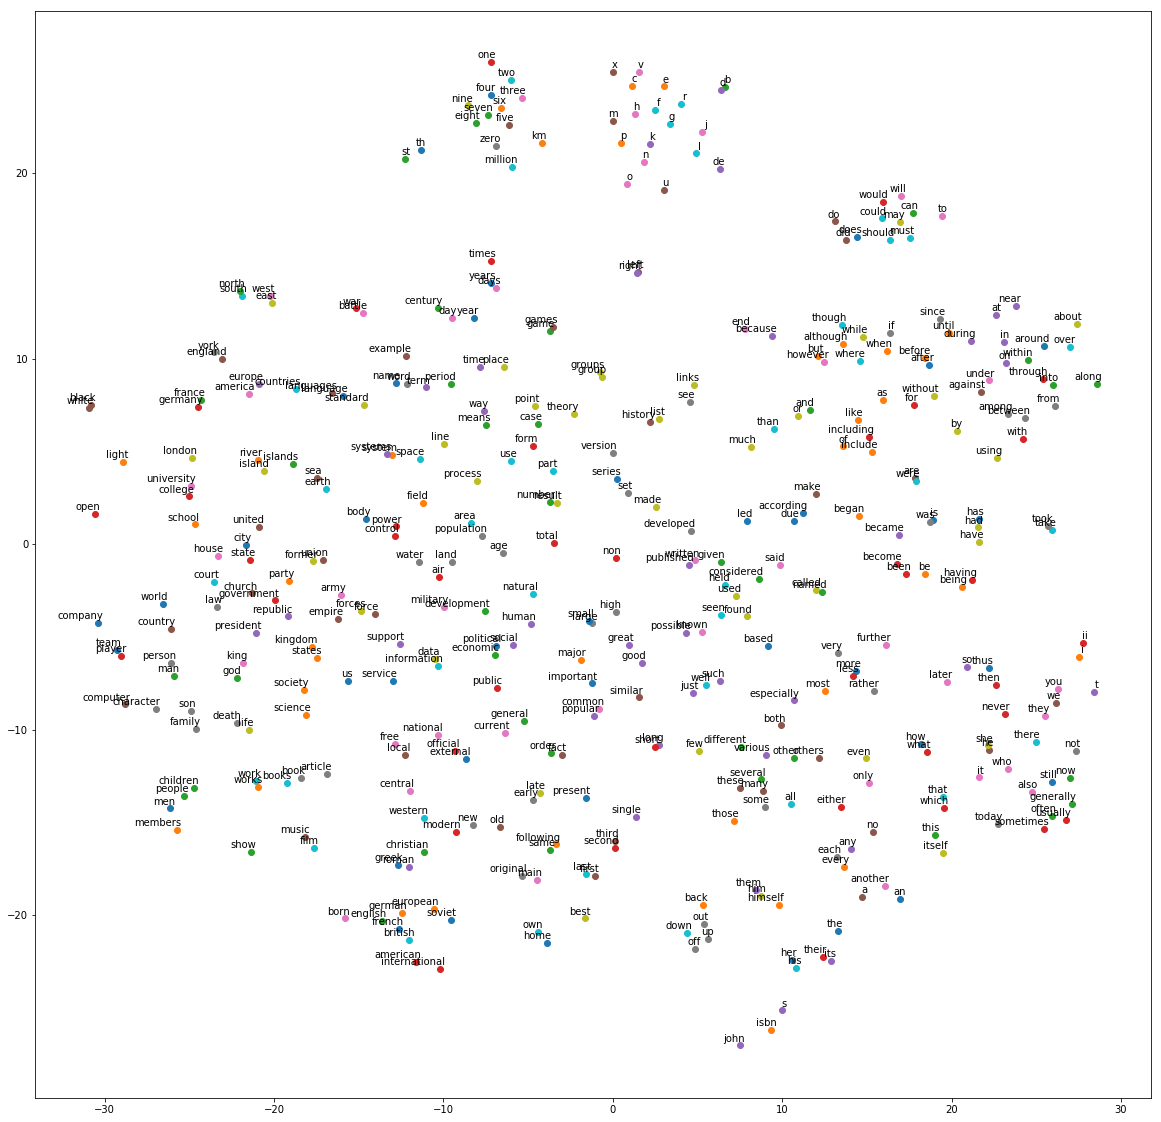

In [50]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(20,20))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

作业：使用CBOW模型训练word2vec，获得embedding并比较和skip-gram的差异
------------
生成样本的方式不同

In [7]:
data_index = 0

def cbow_batch(batch_size, bag_window):
  global data_index
  batch = np.ndarray(shape=(batch_size,bag_window*2), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * bag_window + 1 # [ bag_window target bag_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    batch[i] = list(buffer)[:bag_window] + list(buffer)[bag_window+1:]
    labels[i] = buffer[bag_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:12]])

batch, labels = cbow_batch(8,1)
print('batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])  
print('labels:', [reverse_dictionary[l] for l in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']
batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']


网络定义基本相同，只改变了输入数据的维度和输入前的处理

In [14]:
batch_size = 128
embedding_size = 128 
bag_window = 1 # 跟skip_window作用相同
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # 输入变量的维度不同
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window*2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
 
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # inputs先做sum pooling再输入
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_sum(embed, 1),
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

调用batch样本的生成的方法不同，其他相同

In [ ]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = cbow_batch(batch_size, bag_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
       
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 5 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 6.931688
Nearest to was: formless, male, ki, destabilizing, unconsciousness,
Nearest to it: astros, genitive, specializes, eugenius, chopsticks,
Nearest to be: soliloquy, consecration, dystrophy, extravagant, admin,
Nearest to some: shaw, eee, raged, nicene, slower,
Nearest to two: trademarked, slowing, clipping, encapsulated, falk,
Nearest to are: salian, greeneville, nilsson, bentheim, icao,
Nearest to these: minorca, lvaro, civilisations, thin, silverstein,
Nearest to he: saboteurs, simo, starting, thunderbird, respectively,
Nearest to other: breached, literary, shrinks, diff, touma,
Nearest to s: enunciated, frelimo, hilliard, apprehend, weapon,
Nearest to time: pirandello, redirect, basque, attalus, zhukov,
Nearest to eight: anaheim, swaziland, constituting, dorsal, touchstone,
Nearest to five: dualistic, ambitious, herbie, whipping, confined,
Nearest to american: presented, cretians, bigger, outnumber, headers,
Nearest to between: dipole, nemes

可视化代码相同

In [ ]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(20,20))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)